In [3]:
import os
import pandas as pd

In [4]:
from sklearn.datasets import load_breast_cancer  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import pickle

In [7]:
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, PauliFeatureMap

In [8]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

In [9]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
data = load_breast_cancer()
X, y = data.data, data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
df = pd.DataFrame(X, columns=data.feature_names)

In [20]:
df['target'] = y

In [22]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0


In [23]:
len(data.feature_names)

30

In [39]:
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

In [40]:
pca_path = os.path.join(models_dir, 'pca.pkl')

In [ ]:
if os.path.exists(pca_path):
    with open(pca_path, 'rb') as f:
        pca = pickle.load(f)

    print("Loaded existing PCA transformer.")
    X_train_reduced = pca.transform(X_train)
    X_test_reduced = pca.transform(X_test)

else:
    pca = PCA(n_components=2)

    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    with open(pca_path, 'wb') as f:
        pickle.dump(pca, f)
        
    print("Fitted and saved new PCA transformer.")

In [18]:
def custom_zz_feature_map(feature_dimension, reps):
    
    params = ParameterVector('x', feature_dimension)
    qc = QuantumCircuit(feature_dimension)
    
    for i in range(feature_dimension):
        qc.h(i)
    
    for _ in range(reps):
        
        for i in range(feature_dimension):
            qc.ry(2 * params[i], i)
        
        for i in range(feature_dimension - 1):
            qc.cx(i, i+1)
            qc.rz(2 * params[i], i+1)
            qc.cx(i, i+1)
    return qc

In [19]:
def custom_z_feature_map(feature_dimension, reps):
    
    params = ParameterVector('x', feature_dimension)
    qc = QuantumCircuit(feature_dimension)
    for i in range(feature_dimension):
        qc.h(i)
    for _ in range(reps):
        
        for i in range(feature_dimension):
            qc.rz(2 * params[i], i)
        
        for i in range(feature_dimension - 1):
            qc.cx(i, i+1)
            qc.rx(2 * params[i], i+1)
            qc.cx(i, i+1)
    return qc

In [20]:
def custom_pauli_feature_map(feature_dimension, reps):
    
    params = ParameterVector('x', feature_dimension)
    qc = QuantumCircuit(feature_dimension)

    for i in range(feature_dimension):
        qc.h(i)

    for _ in range(reps):
        
        for i in range(feature_dimension):
            qc.rz(2 * params[i], i)
            qc.rx(2 * params[i], i)
            qc.ry(2 * params[i], i)
        
        for i in range(feature_dimension - 1):
            qc.cx(i, i+1)
            qc.rz(2 * params[i], i+1)
            qc.cx(i, i+1)
    return qc

In [21]:
def build_real_amplitudes_ansatz(num_qubits, reps=1):    
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=reps, entanglement='full')    
    bound_ansatz = ansatz.bind_parameters({param: 0 for param in ansatz.parameters})
    return bound_ansatz

In [22]:
num_features = X_train_reduced.shape[1]

In [23]:
num_features

2

In [24]:
reps = 2

In [25]:
ansatz = build_real_amplitudes_ansatz(num_qubits=num_features, reps=1)

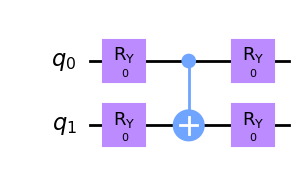

In [26]:
ansatz.decompose().draw('mpl')

In [27]:
zz_map = custom_zz_feature_map(num_features, reps)
final_circuit_zz = zz_map.compose(ansatz)

z_map = custom_z_feature_map(num_features, reps)
final_circuit_z = z_map.compose(ansatz)

pauli_map = custom_pauli_feature_map(num_features, reps)
final_circuit_pauli = pauli_map.compose(ansatz)

In [ ]:
## ------ Creating Kernels using the custom feature maps ------ ##

# zz_map = ZZFeatureMap(feature_dimension=num_features, reps=reps)

# z_map = ZFeatureMap(feature_dimension=num_features, reps=reps)

# pauli_map = PauliFeatureMap(feature_dimension=num_features, reps=reps, entanglement='full', paulis=['Z', 'X', 'Y'])

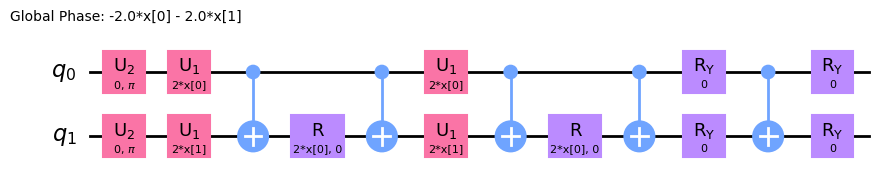

In [29]:
final_circuit_z.decompose().draw(output='mpl')

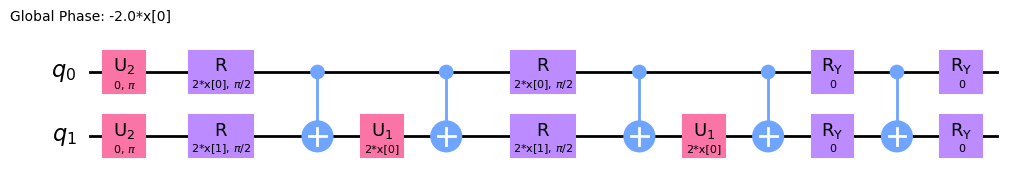

In [30]:
final_circuit_zz.decompose().draw(output='mpl')

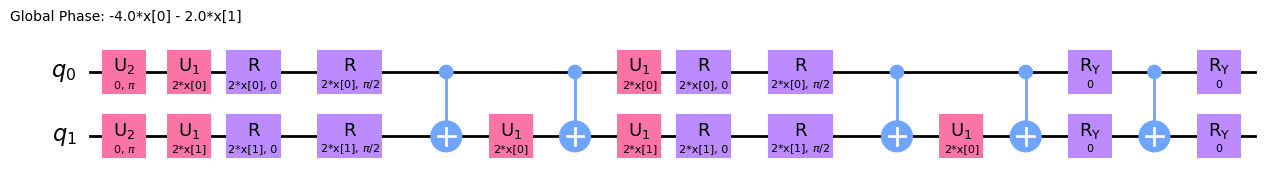

In [31]:
final_circuit_pauli.decompose().draw(output='mpl')

In [32]:
final_circuit_zz.num_parameters

2

In [33]:
final_circuit_pauli.num_parameters

2

In [34]:
algorithm_globals.random_seed = 42

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

quantum_kernel_zz = FidelityQuantumKernel(feature_map=final_circuit_zz, fidelity=fidelity)
quantum_kernel_z = FidelityQuantumKernel(feature_map=final_circuit_z, fidelity=fidelity)
quantum_kernel_pauli = FidelityQuantumKernel(feature_map=final_circuit_pauli, fidelity=fidelity)


In [35]:
def load_or_train_qsvc(model_path, X_train, y_train, quantum_kernel):   
    if os.path.exists(model_path):
        
        with open(model_path, 'rb') as file:
            qsvc = pickle.load(file)
            
        print("QSVC model loaded from disk.")

    else:        
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train, y_train)

        with open(model_path, 'wb') as file:
            pickle.dump(qsvc, file)

        print("QSVC model trained and saved to disk.")

    return qsvc


In [36]:
def load_or_train_svc(model_path, X_train, y_train):   
    if os.path.exists(model_path):
        
        with open(model_path, 'rb') as file:
            svc = pickle.load(file)
            
        print("SVC model loaded from disk.")

    else:        
        svc = SVC(kernel='rbf', C=1.0, gamma='scale')
        svc.fit(X_train, y_train)

        with open(model_path, 'wb') as file:
            pickle.dump(svc, file)

        print("SVC model trained and saved to disk.")

    return svc


In [37]:
model_path_zz = 'models\qsvc_zz.pkl'
model_path_z = 'models\qsvc_z.pkl' 
model_path_pauli = 'models\qsvc_pauli.pkl'


In [38]:
qsvc_zz = load_or_train_qsvc(model_path_zz, X_train_reduced, y_train, quantum_kernel_zz)

QSVC model loaded from disk.


In [44]:
train_score_zz = qsvc_zz.score(X_train_reduced, y_train)
test_score_zz = qsvc_zz.score(X_test_reduced, y_test)

print(f"QSVC Training accuracy: {train_score_zz:.2f}")
print(f"QSVC Test accuracy: {test_score_zz:.2f}")


QSVC Training accuracy: 0.00
QSVC Test accuracy: 0.00


In [ ]:
classification_report(y_test, qsvc_zz.predict(X_test_reduced), target_names=data.target_names)

In [ ]:
qsvc_z = load_or_train_qsvc(model_path_z, X_train_reduced, y_train, quantum_kernel_z)

QSVC model trained and saved to disk.


In [48]:
train_score_z = qsvc_z.score(X_train_reduced, y_train)
test_score_z = qsvc_z.score(X_test_reduced, y_test)

print(f"QSVC for Z Feature Map Training accuracy: {train_score_z:.2f}")
print(f"QSVC for Z Feature Map Test accuracy: {test_score_z:.2f}")


QSVC for Z Feature Map Training accuracy: 0.63
QSVC for Z Feature Map Test accuracy: 0.62


In [42]:
qsvc_pauli = load_or_train_qsvc(model_path_pauli, X_train_reduced, y_train, quantum_kernel_pauli)

QSVC model loaded from disk.


In [43]:
train_score_qsvc_pauli = qsvc_pauli.score(X_train_reduced, y_train)
test_score_qsvc_pauli = qsvc_pauli.score(X_test_reduced, y_test)

print(f"QSVC Pauli Training accuracy: {train_score_qsvc_pauli:.2f}")
print(f"QSVC Pauli Test accuracy: {test_score_qsvc_pauli:.2f}")


QSVC Pauli Training accuracy: 0.63
QSVC Pauli Test accuracy: 0.62


In [ ]:
classic_model_path = 'models\svc_model.pkl'

In [45]:
svc = load_or_train_svc(classic_model_path, X_train_reduced, y_train)

SVC model loaded from disk.


In [46]:
train_score_svc = svc.score(X_train_reduced, y_train)
test_score_svc = svc.score(X_test_reduced, y_test)

print(f"Classical SVM Training accuracy: {train_score_svc:.2f}")
print(f"Classical SVM Test accuracy: {test_score_svc:.2f}")


Classical SVM Training accuracy: 0.93
Classical SVM Test accuracy: 0.96


In [31]:
def predict_with_model(X_array, model_name, models_dir='models'):

    pca_path = os.path.join(models_dir, 'pca.pkl')
    if not os.path.exists(pca_path):
        raise FileNotFoundError("PCA transformer not found. Please train and save PCA first.")
    with open(pca_path, 'rb') as f:
        pca = pickle.load(f)
    
    X_reduced = pca.transform([X_array])
    
    model_path = os.path.join(models_dir, f"{model_name}.pkl")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model '{model_name}' not found in {models_dir}.")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    preds = model.predict(X_reduced)
    
    return preds[0]

In [32]:
predict_with_model(X_test[1], 'svc_model', models_dir='models')

0

In [37]:
predict_with_model(X_test[1], 'qsvc_z', models_dir='models')

1